In [1]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [168]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

## Load images from directory

In [169]:
train_image_dir = '/home/gaurav/datasets/agri/Tomato_Classifier/MultiClassData'

In [170]:
train_generator = train_datagen.flow_from_directory(train_image_dir,
                                                    target_size=(256, 256),
                                                    batch_size=64,
                                                    class_mode='categorical')

Found 18160 images belonging to 10 classes.


In [171]:
train_generator.class_indices

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites_Two_spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

In [172]:
image_shape = train_generator.image_shape

In [173]:
train_generator.n

18160

## Read the Images

In [174]:
x_batch, y_batch = next(train_generator)

In [175]:
x_batch.shape

(64, 256, 256, 3)

In [176]:
y_batch.shape

(64, 10)

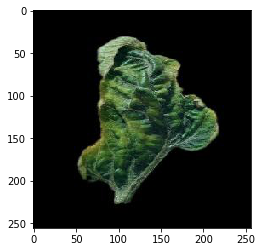

In [177]:
plt.imshow( x_batch[0] );
plt.grid(False)    
plt.show();

### Show random images from a batch

In [178]:
import random 

def show_random_images( x_batch_images, y_batch_images ):

    all_indexes = list(range(len(x_batch_images)))
    random_indexes = random.sample( all_indexes, 8 )

    plt.figure( figsize=(16, 8))
    
    k = 1    
    for i in random_indexes:
        plt.subplot(2, 4, k);
        plt.grid(False)
        plt.imshow(x_batch_images[i])
        plt.title(y_batch_images[i])
        k = k + 1

    plt.show()

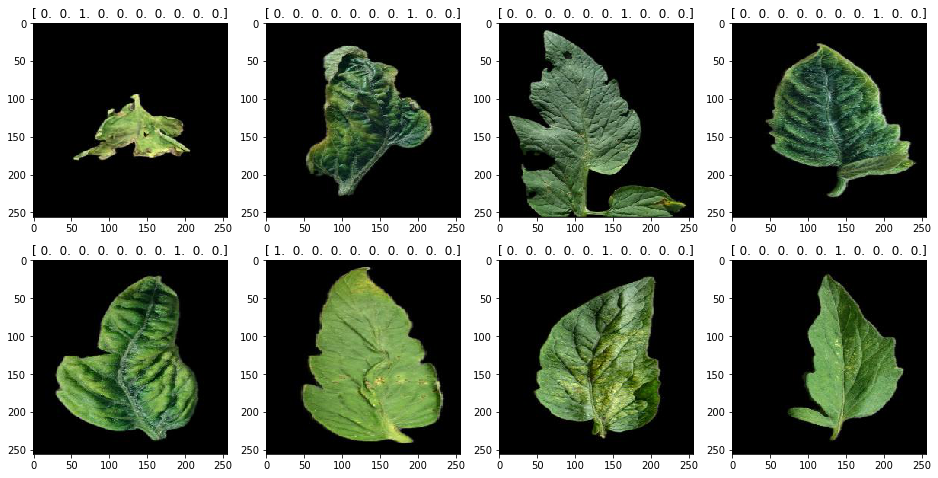

In [179]:
show_random_images( x_batch, y_batch )

### ZCA Whiteing

A whitening transform minimizes the redundancy in the matrix of pixel images. Initutively, it highlights the pixels with high variance across images.  

Image whitening uses the same dimesional reduction technique as Principal Component Analysis (PCA), alternative called ZCA. However the transformed image retains the same dimensions of original image.

You can perform a ZCA whitening transform by setting the zca_whitening argument to True in *ImageDataGenerator*.

In [137]:
zca_train_datagen = ImageDataGenerator(zca_whitening=True)

zca_train_generator = zca_train_datagen.flow_from_directory(train_image_dir,
                                                    target_size=(256, 256),
                                                    batch_size=8,
                                                    class_mode='categorical')

Found 18160 images belonging to 10 classes.


In [138]:
x_zca_batch, y_batch = next(zca_train_generator)

/opt/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:556: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [139]:
x_zca_batch.shape

(8, 256, 256, 3)

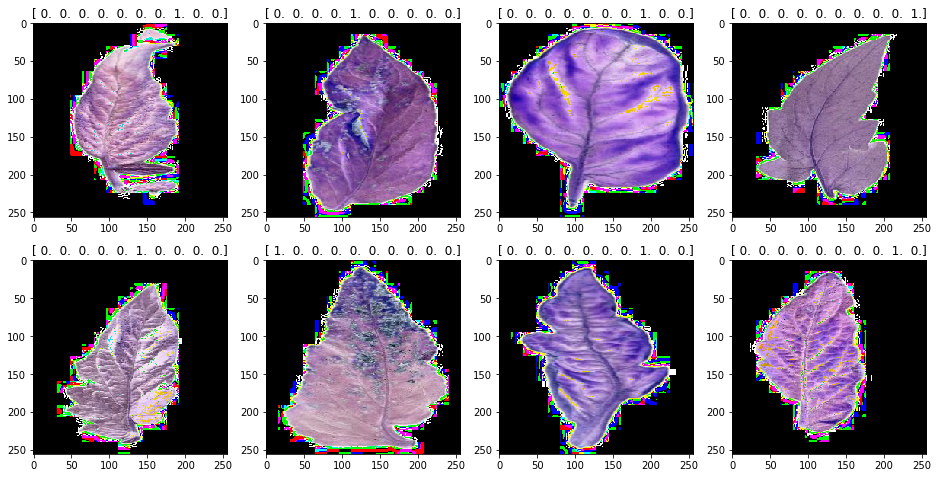

In [140]:
show_random_images( x_zca_batch, y_batch )

### Image Rotations

The training dataset contains images, which are mostly aligned vertically. But while predicting users may take leaf images from many different angles. So we augment our training samples by randomly rotating images from 0 to 90 degrees.

In [77]:
rotate_train_datagen = ImageDataGenerator(rotation_range=90, 
                                          rescale=1./256)

rotate_train_generator = rotate_train_datagen.flow_from_directory(train_image_dir,
                                                    target_size=(256, 256),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 18160 images belonging to 10 classes.


In [78]:
x_rotate_batch, y_batch = next(rotate_train_generator)

In [79]:
x_rotate_batch.shape

(32, 256, 256, 3)

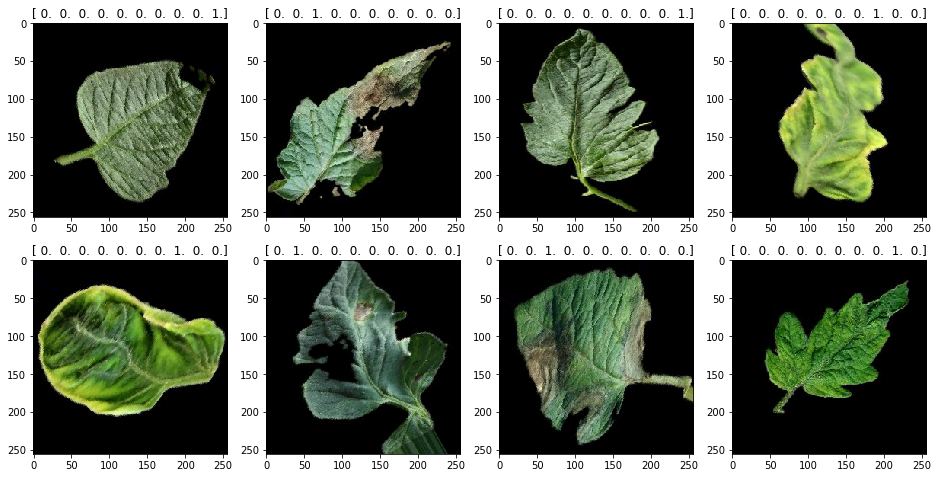

In [80]:
show_random_images(x_rotate_batch, y_batch)

## Zooming In and Out

In [83]:
zoom_train_datagen = ImageDataGenerator(zoom_range=0.4, 
                                        rescale=1./256)

zoom_train_generator = zoom_train_datagen.flow_from_directory(train_image_dir,
                                                    target_size=(256, 256),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 18160 images belonging to 10 classes.


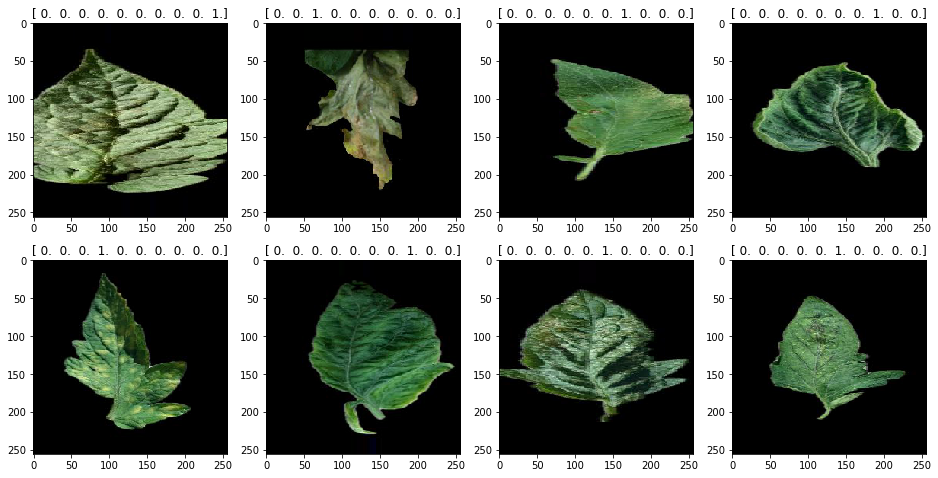

In [85]:
x_zoom_batch, y_batch = next(zoom_train_generator)
show_random_images(x_zoom_batch, y_batch)

### Shifting Images

In [86]:
shift_train_datagen = ImageDataGenerator(rescale=1./256,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2)

shift_train_generator = shift_train_datagen.flow_from_directory(train_image_dir,
                                                    target_size=(256, 256),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 18160 images belonging to 10 classes.


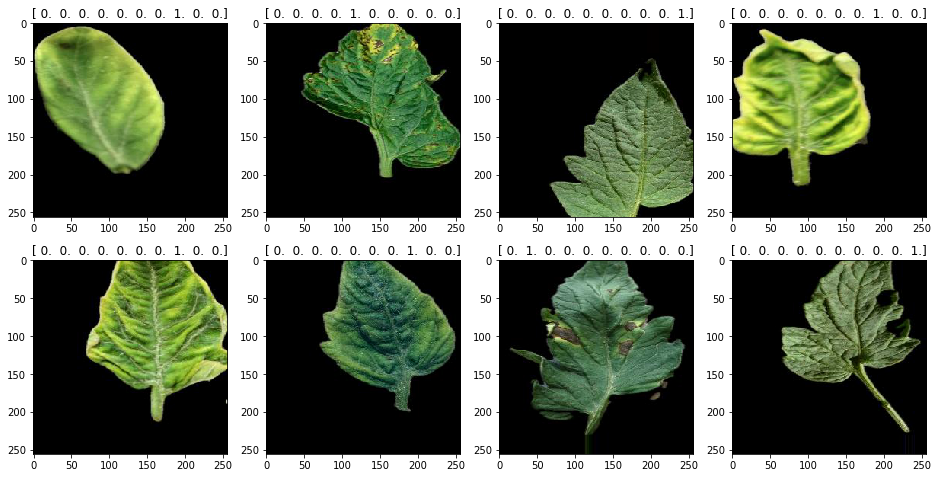

In [87]:
x_shift_batch, y_batch = next(shift_train_generator)
show_random_images(x_shift_batch, y_batch)

### Combining multiple data augmentation techniques

In [129]:
augmented_train_datagen = ImageDataGenerator(rescale=1./256,
                                         rotation_range=90,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         zoom_range=0.4)

augmented_train_generator = augmented_train_datagen.flow_from_directory(train_image_dir,
                                                    target_size=(256, 256),
                                                    batch_size=128,
                                                    class_mode='categorical')

Found 18160 images belonging to 10 classes.


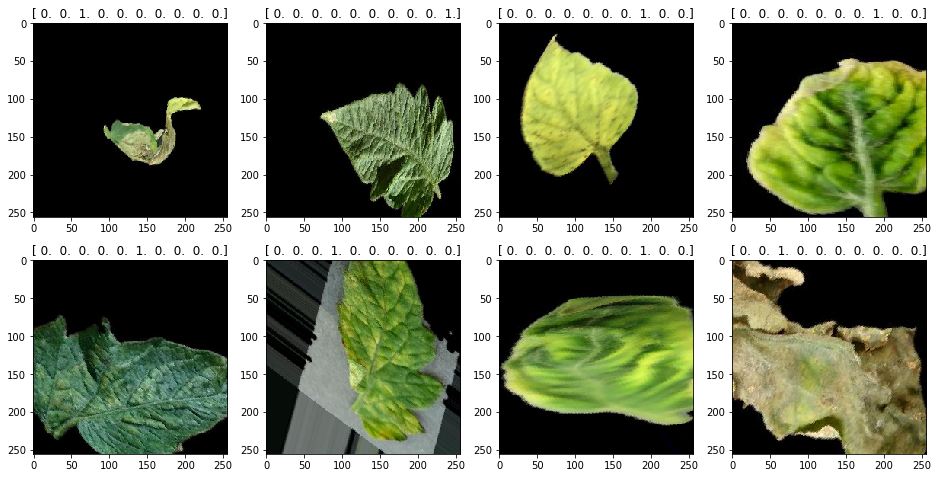

In [130]:
x_augmented_batch, y_batch = next(augmented_train_generator)
show_random_images(x_augmented_batch, y_batch)

### Building a model

In [131]:
import keras.backend as K
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Input
from keras.layers.advanced_activations import LeakyReLU

In [132]:
K.clear_session()  # clear default graph

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, padding='same', input_shape=image_shape))
model.add(LeakyReLU(0.1))
                            
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', input_shape=image_shape))
model.add(LeakyReLU(0.1))
                            
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', input_shape=image_shape))
model.add(LeakyReLU(0.1))
                            
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())
    
model.add(Dense(256))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

In [133]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [134]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [135]:
callbacks_list = [ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.1, 
                                    patience=2),
                 EarlyStopping(monitor='val_loss',
                               patience=2),
                 ModelCheckpoint(filepath='my_model.h5',
                                 monitor='val_loss',
                                 save_best_only=True)]

In [ ]:
%%time

history = model.fit_generator(augmented_train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              callbacks=callbacks_list,
                              validation_data=augmented_train_generator,
                              validation_steps=5)

Epoch 1/50
  1/100 [..............................] - ETA: 5:58 - loss: 2.3027 - acc: 0.1484

In [ ]:
import pickle

pickle.dump( history.history, open('history_aug_nozca.pkl', 'wb') )

In [139]:
# summarize history for accuracy

def plot_train_val_accuracy(hist):
    plt.plot(hist['acc'])
    plt.plot(hist['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [140]:
# summarize history for loss

def plot_train_val_loss(hist):
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

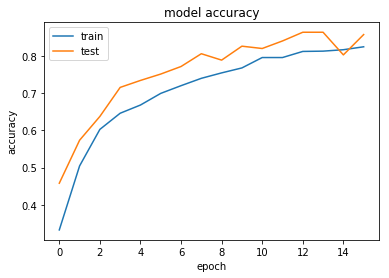

In [141]:
plot_train_val_accuracy( history.history )

In [144]:
history.history.values()

dict_values([[1.6930552005767823, 1.1860181212425231, 0.99820685386657715, 0.80898935794830318, 0.81475383043289185, 0.72626569271087649, 0.72597421407699581, 0.56737754344940183, 0.56401540040969844, 0.5064514636993408, 0.52524111866950984, 0.45287330150604249, 0.41056849956512453, 0.38887485861778259, 0.55936567783355717, 0.41950021982192992], [0.45781250000000001, 0.57343750000000004, 0.63749999999999996, 0.71562499999999996, 0.734375, 0.75156250000000002, 0.77187499999999998, 0.80625000000000002, 0.7890625, 0.82656249999999998, 0.8203125, 0.84062499999999996, 0.86406249999999996, 0.86406249999999996, 0.80312499999999998, 0.85781249999999998], [1.9625375175356716, 1.4699903662422571, 1.1788077223300935, 1.0496122674440711, 0.95910639286041255, 0.87780350752557179, 0.81135091510075652, 0.75809001206456494, 0.72435181049888808, 0.68049340993165974, 0.61756345320105999, 0.60163120841502549, 0.56277682274579999, 0.55381293999537062, 0.54568292299409082, 0.52964353919029239], [0.33213391

### Combined Data Augmentation + whitening

In [180]:
augmented_zca_train_datagen = ImageDataGenerator(rotation_range=90,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         zoom_range=0.4,
                                         zca_whitening=True)

augmented_zca_train_generator = augmented_zca_train_datagen.flow_from_directory(train_image_dir,
                                                    target_size=(256, 256),
                                                    batch_size=128,
                                                    class_mode='categorical')

Found 18160 images belonging to 10 classes.


/opt/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:556: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


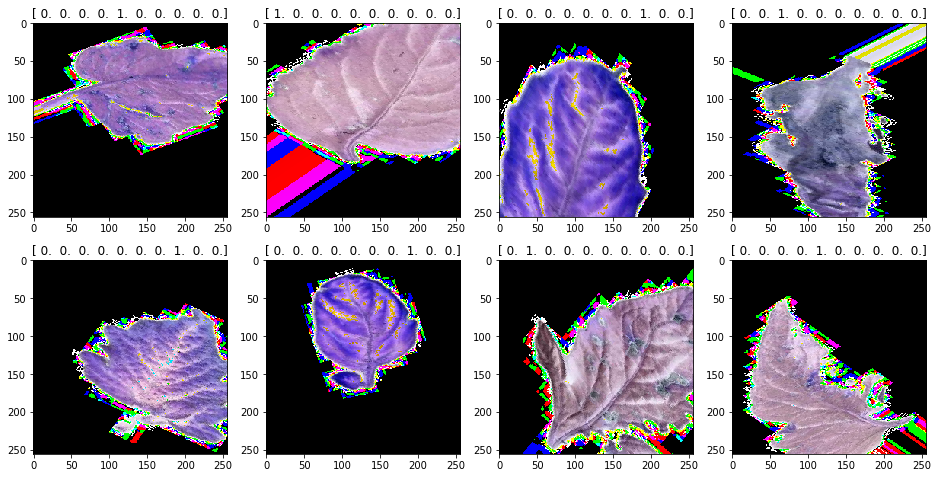

In [181]:
x_augmented_zca_batch, y_batch = next(augmented_zca_train_generator)
show_random_images(x_augmented_zca_batch, y_batch)

In [185]:
K.clear_session()  # clear default graph

model_zca = Sequential()
model_zca.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, padding='same', input_shape=image_shape))
model_zca.add(LeakyReLU(0.1))
                            
model_zca.add(MaxPooling2D(pool_size=(3, 3)))

model_zca.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', input_shape=image_shape))
model_zca.add(LeakyReLU(0.1))
                            
model_zca.add(MaxPooling2D(pool_size=(3, 3)))

model_zca.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', input_shape=image_shape))
model_zca.add(LeakyReLU(0.1))
                            
model_zca.add(MaxPooling2D(pool_size=(3, 3)))

model_zca.add(Flatten())
    
model_zca.add(Dense(256))
model_zca.add(LeakyReLU(0.1))
model_zca.add(Dropout(0.5))

model_zca.add(Dense(64))
model_zca.add(LeakyReLU(0.1))
model_zca.add(Dropout(0.5))

model_zca.add(Dense(10))
model_zca.add(Activation('softmax'))

In [186]:
model_zca.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [187]:
callbacks_list = [ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.1, 
                                    patience=2),
                 EarlyStopping(monitor='val_loss',
                               patience=2),
                 ModelCheckpoint(filepath='my_model.h5',
                                 monitor='val_loss',
                                 save_best_only=True)]

In [ ]:
%%time

history_zca = model_zca.fit_generator(augmented_train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              callbacks=callbacks_list,
                              validation_data=augmented_train_generator,
                              validation_steps=5)

Epoch 1/50
100/100 [==============================] - 254s 3s/step - loss: 1.9283 - acc: 0.3401 - val_loss: 1.6466 - val_acc: 0.4391
Epoch 2/50
 49/100 [=============>................] - ETA: 1:57 - loss: 1.5914 - acc: 0.4412

In [ ]:
pickle.dump( history.history, open('history_aug_zca.pkl', 'wb') )

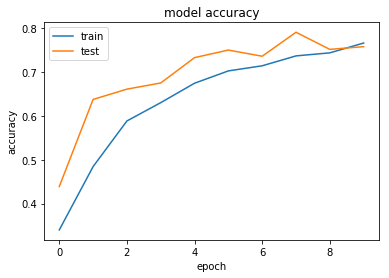

In [190]:
plot_train_val_accuracy(history_zca.history)